This notebook prepares the [Grocery Dataset](https://github.com/gulvarol/grocerydataset) to train an object detection model to detect products from a store shelf image. 

## Gather data sources

In [ ]:
!wget -q https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
!tar xf ShelfImages.tar.gz

In [ ]:
!wget -q https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz
!tar xf GroceryDataset_part2.tar.gz

In [ ]:
!ls -lh ShelfImages | head -10
!ls -lh ShelfImages/train | head -10
!ls -lh ShelfImages/test | head -10

total 20K
drwxrwxr-x 2 1001 1001 4.0K Aug 28 10:53 test
drwxrwxr-x 2 1001 1001  16K Aug 28 10:53 train
total 456M
-rw-r--r-- 1 1001 1001  645K Oct 23  2019 C1_P01_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N1_S2_2.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001  870K Oct 23  2019 C1_P01_N1_S3_2.JPG
-rw-r--r-- 1 1001 1001  907K Oct 23  2019 C1_P01_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001  1.3M Oct 23  2019 C1_P01_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N2_S4_1.JPG
-rw-r--r-- 1 1001 1001  2.0M Oct 23  2019 C1_P01_N3_S2_1.JPG
total 101M
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P02_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001 1.3M Oct 23  2019 C1_P03_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P03_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001 2.4

From [here](https://github.com/gulvarol/grocerydataset#shelfimages) we can get a sense of how an individual image is named:

```
"C<c>_P<p>_N<n>_S<s>_<i>.JPG"
    where
        <c> := camera id (1: iPhone5S, 2: iPhone4, 3: Sony Cybershot, 4: Nikon Coolpix)
        <p> := planogram id
        <n> := the rank of the top shelf on the image according to the planogram
        <s> := number of shelves on the image
        <i> := copy number
```

## Imports

In [ ]:
from imutils import paths
from typing import List
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Visualize the raw images

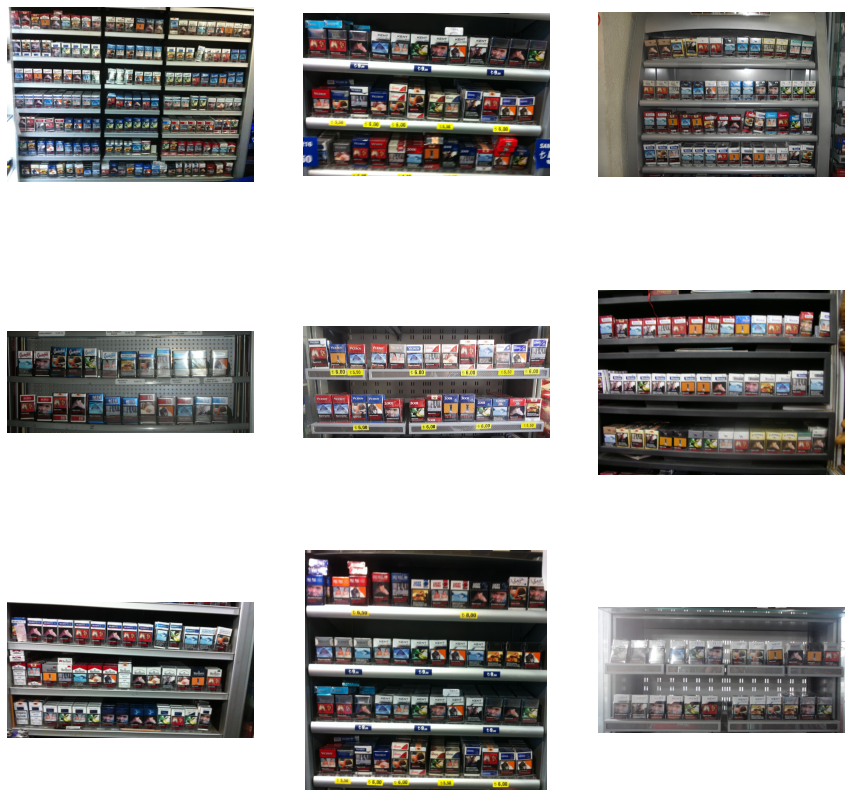

In [ ]:
train_images = list(paths.list_images("ShelfImages/train"))
plt.figure(figsize=(15, 15))
for i, image  in enumerate(train_images[:9]):
    image = plt.imread(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

A question that gets raised here - how do I map these images to their detection annotations? From [here](https://github.com/gulvarol/grocerydataset#annotationtxt) we have the following information (which is summarized in [`annotations.csv`](https://github.com/gulvarol/grocerydataset/blob/master/annotations.csv)) - 

```
<shelf image name> <n> <x_1> <y_1> <w_1> <h_1> <b_1> <x_2> <y_2> <w_2> <h_2> <b_2> ... <x_n> <y_n> <w_n> <h_n> <b_n>
    where
        <shelf image name>   := shelf image name
        <n>                  := number of product on the shelf image
        <x_i>                := x-coordinate of the i'th product image
        <y_i>                := y-coordinate of the i'th product image
        <w_i>                := width of the i'th product image
        <h_i>                := height of the i'th product image
        <b_i>                := brand of the i'th product image
```

## Visualize bbox annotations 

In [ ]:
cols = ["image_name", "x_i", "y_i", "w_i", "h_i", "b_i"]
master_df = pd.read_csv("https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv", 
                        names=cols)
master_df.head()

,image_name,x_i,y_i,w_i,h_i,b_i
0,C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0
1,C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0
2,C1_P01_N1_S2_1.JPG,24,872,268,1264,0
3,C1_P01_N1_S2_1.JPG,280,1568,532,1944,0
4,C1_P01_N1_S2_1.JPG,292,872,544,1248,0


In [ ]:
# How many unique brands? (0 stands for "other" class)
master_df["b_i"].unique()

array([ 0,  1,  4,  7,  3,  6, 10,  2,  5,  8,  9])

Let's visualize a few images with their respective annotations. We will write a small utility for this purpose. 

In [ ]:
def vis_annotations(image_path: str, coordinate_list: List[List[int]], 
                    color: str="blue") -> None:
    """Converts bounding box to matplotlib format, imposes it on the 
    provided image and then displays the plot."""
    image = plt.imread(image_path)
    fig = plt.imshow(image)
    for i in range(len(coordinate_list)):
        bbox = coordinate_list[i]
        fig.axes.add_patch(plt.Rectangle(
            xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
            fill=False, edgecolor=color, linewidth=2))
    plt.show()

Let's start with the first image from the dataframe above. Its absolute path is present in `train_images`.

In [ ]:
train_images[0]

'ShelfImages/train/C2_P09_N1_S7_2.JPG'

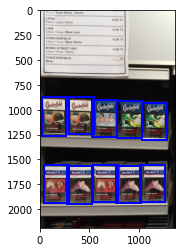

In [ ]:
coordinate_columns = master_df.columns[1:-1]
coordinate_list = master_df[master_df["image_name"]=="C1_P01_N1_S2_1.JPG"][coordinate_columns]
coordinate_list = coordinate_list.values.tolist()
vis_annotations("ShelfImages/train/C1_P01_N1_S2_1.JPG", coordinate_list)

## Splitting into train and test dataframes

We already have the train and test images segregated. We can use that information to split `master_df` into train and test dataframes. 

In [ ]:
# Grab the image names belonging to the train and test sets
train_images = list(paths.list_images("ShelfImages/train"))
test_images = list(paths.list_images("ShelfImages/test"))
train_image_names = [image_path.split("/")[-1] for image_path in train_images]
test_image_names = [image_path.split("/")[-1] for image_path in test_images]
print(len(train_image_names), len(test_image_names))

283 71


In [ ]:
# Create two different dataframes from train and test sets
train_df = master_df[master_df["image_name"].isin(train_image_names)]
test_df = master_df[~master_df["image_name"].isin(train_image_names)]
print(len(np.unique(train_df["image_name"])), len(np.unique(test_df["image_name"])))

283 71


In [ ]:
# Let's turn the image names into absolute paths
train_df["image_name"] = train_df["image_name"].map(lambda x: "ShelfImages/train/" + x)
test_df["image_name"] = test_df["image_name"].map(lambda x: "ShelfImages/test/" + x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Preview
train_df.head()

,image_name,x_i,y_i,w_i,h_i,b_i
0,ShelfImages/train/C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0
1,ShelfImages/train/C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0
2,ShelfImages/train/C1_P01_N1_S2_1.JPG,24,872,268,1264,0
3,ShelfImages/train/C1_P01_N1_S2_1.JPG,280,1568,532,1944,0
4,ShelfImages/train/C1_P01_N1_S2_1.JPG,292,872,544,1248,0


## Setup TFOD API

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf 
print(tf.__version__)

!git clone https://github.com/tensorflow/models.git

% cd models/research
!pip install --upgrade pip
# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf1/setup.py .
!python -m pip install --use-feature=2020-resolver .

TensorFlow 1.x selected.
1.15.2
Cloning into 'models'...
remote: Enumerating objects: 60837, done.
remote: Counting objects: 100% (616/616), done.
remote: Compressing objects: 100% (385/385), done.
remote: Total 60837 (delta 355), reused 460 (delta 213), pack-reused 60221
Receiving objects: 100% (60837/60837), 574.15 MiB | 37.08 MiB/s, done.
Resolving deltas: 100% (42271/42271), done.
/content/models/research
     |████████████████████████████████| 1.6 MB 7.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this

## Generating TFRecords

We will be using the [TFOD API](https://github.com/tensorflow/models/tree/master/research/object_detection) to train the detection model. The API expects TFRecords as its inputs. So, before we start the model training process we first need to represent our dataset in terms of TFRecords only. 

A single example inside the TFRecords should have the following entries - 
* filename, 
* width, 
* height, 
* class, 
* xmin, 
* ymin, 
* xmax, 
* ymax

**Note**: Although the official repository of the Grocery Dataset mentions that there are width and height coordinates I don't they are so. I think they are bottom-right coordinates. Also, TFOD API reserves 0 for the background label. Therefore, we will add 1 to all the brand IDs.

Given all of these, let's start by writing a utility to create our dataframes in the expected format. 

In [ ]:
def prepare_df(original_df):
    df = pd.DataFrame()
    df["filename"] = original_df["image_name"]
    df["wdith"] = (original_df["x_i"] - original_df["w_i"]).astype("int")
    df["height"] = (original_df["y_i"] - original_df["h_i"]).astype("int")
    df["class"] = (original_df["b_i"] + 1).astype("int")
    df["xmin"] = (original_df["x_i"]).astype("int") 
    df["ymin"] = (original_df["y_i"]).astype("int")
    df["xmax"] = (original_df["w_i"]).astype("int") 
    df["ymax"] = (original_df["h_i"]).astype("int")
    return df

In [ ]:
new_train_df = prepare_df(train_df)
new_test_df = prepare_df(test_df)
print(len(np.unique(new_train_df["filename"])), len(np.unique(new_test_df["filename"])))

283 71


In [ ]:
# Serialize these dataframes
new_train_df.to_csv("train.csv", index=False)
new_test_df.to_csv("test.csv", index=False)

In [ ]:
!ls -lh * /content/detect.csv

-rw-r--r--  1 root root 7.6K Aug 28 11:03 /content/detect.csv
-rw-r--r--  1 root root 3.2K Aug 28 10:58 generate_tfrecord.py
-rw-r--r--  1 root root 7.0K Aug 28 10:57 README.md
-rw-r--r--  1 root root  978 Aug 28 10:57 setup.py
-rw-r--r--  1 root root 172K Aug 28 10:58 test.csv
-rw-r--r--  1 root root 693K Aug 28 10:58 train.csv

adversarial_text:
total 124K
-rw-r--r-- 1 root root 9.0K Aug 28 10:57 adversarial_losses.py
drwxr-xr-x 2 root root 4.0K Aug 28 10:57 data
-rw-r--r-- 1 root root 4.6K Aug 28 10:57 evaluate.py
-rw-r--r-- 1 root root 7.8K Aug 28 10:57 gen_data.py
-rw-r--r-- 1 root root 3.2K Aug 28 10:57 gen_vocab.py
-rw-r--r-- 1 root root  25K Aug 28 10:57 graphs.py
-rw-r--r-- 1 root root 7.0K Aug 28 10:57 graphs_test.py
-rw-r--r-- 1 root root    0 Aug 28 10:57 __init__.py
-rw-r--r-- 1 root root  12K Aug 28 10:57 inputs.py
-rw-r--r-- 1 root root  14K Aug 28 10:57 layers.py
-rw-r--r-- 1 root root 1.5K Aug 28 10:57 pretrain.py
-rw-r--r-- 1 root root 4.9K Aug 28 10:57 README.md
-rw-

I wrote this [utility script](https://gist.github.com/sayakpaul/d82a43c03089a8abfb5b042ee89eeb32) to help us generate the TFRecords.

In [ ]:
!wget -q -O generate_tfrecord.py https://gist.githubusercontent.com/sayakpaul/d82a43c03089a8abfb5b042ee89eeb32/raw/fee76357235803c6a0d2d8859e72542c7a916340/generate_tfrecord.py

In [ ]:
!python generate_tfrecord.py \
    --csv_input=/content/models/research/train.csv \
    --output_path=/content/train.record
!python generate_tfrecord.py \
    --csv_input=/content/models/research/test.csv \
    --output_path=/content/test.record

!ls -lh * /content/detect.record



W0828 11:04:46.634686 140672292210560 module_wrapper.py:139] From generate_tfrecord.py:78: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0828 11:04:46.693619 140672292210560 module_wrapper.py:139] From generate_tfrecord.py:37: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Traceback (most recent call last):
  File "generate_tfrecord.py", line 91, in <module>
    tf.app.run()
  File "/tensorflow-1.15.2/python3.7/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "generate_tfrecord.py", line 82, in main
    tf_example = create_tf_example(group)
  File "generate_tfrecord.py", line 38, in create_tf_example
    enco

## Generate `.pbtxt`

We need to generate a `.pbtxt` file that defines a mapping between our classes and integers. In our case, the classes are already integers. But we still need this file for the TFOD API to operate. 

In [ ]:
classes = new_train_df["class"].unique()
label_encodings = {}
for cls in classes:
    label_encodings[str(cls)] = int(cls)

f = open("/content/label_map.pbtxt", "w")

for (k, v) in label_encodings.items():
    item = ("item {\n"
            "\tid: " + str(v) + "\n"
            "\tname: '" + k + "'\n"
            "}\n")
    f.write(item)

f.close()

!cat /content/label_map.pbtxt

item {
	id: 1
	name: '1'
}
item {
	id: 2
	name: '2'
}
item {
	id: 5
	name: '5'
}
item {
	id: 8
	name: '8'
}
item {
	id: 4
	name: '4'
}
item {
	id: 7
	name: '7'
}
item {
	id: 11
	name: '11'
}
item {
	id: 3
	name: '3'
}
item {
	id: 6
	name: '6'
}
item {
	id: 9
	name: '9'
}
item {
	id: 10
	name: '10'
}


## Moving files to Google Drive for later usage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir /content/drive/MyDrive/product-detection
!cp -r * /content/product-detection.record /content/drive/MyDrive/product-detection
!cp -r * /content/product-detection.pbtxt /content/drive/MyDrive/product-detection

SyntaxError: ignored